In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random
from scipy.linalg import sqrtm
import pandas as pd
import os

from geoclip import geoclip
from geoclip_rank_k import geoclip_with_rank_k_update

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# Example Usage of GeoClip (Algorithm 1)

## Synthetic Dataset

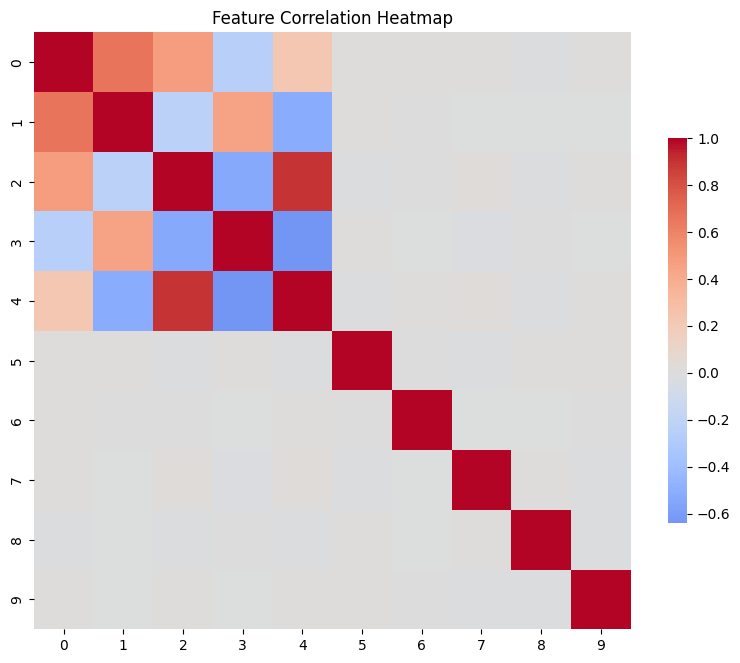

Length of training dataset: 16000
Length of testing dataset: 4000
Shape of one training sample (features): torch.Size([10])
Shape of one training sample (target): torch.Size([1])


In [2]:
def generate_synthetic_regression_data(
        n_samples=20000,
        input_dim=10,
        noise_std=0.01,
        plot_corr=True,
        seed=42):

    # Set seed
    set_seed(seed)

    # Ground truth weights and bias
    true_w = torch.randn(input_dim, 1)
    true_b = torch.randn(1)

    # Generate 5 correlated features
    A_corr = torch.randn(5, 5)
    X_corr = torch.randn(n_samples, 5) @ A_corr.T

    # Generate 5 independent features
    X_indep = torch.randn(n_samples, input_dim - 5)

    # Combine them
    X = torch.cat([X_corr, X_indep], dim=1)

    # Targets with Gaussian noise
    noise = noise_std * torch.randn(n_samples, 1)
    y = X @ true_w + true_b + noise

    # Wrap into dataset
    dataset = TensorDataset(X, y)
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=seed)

    # Plot correlation matrix
    if plot_corr:
        df = pd.DataFrame(X.numpy())
        corr_matrix = df.corr()
        plt.figure(figsize=(8, 8))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": 0.5})
        plt.title("Feature Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    return train_dataset, test_dataset, true_w, true_b


# Generate synthetic data
train_dataset, test_dataset, true_w, true_b = generate_synthetic_regression_data(
    n_samples=20000, input_dim=10, noise_std=0.01, plot_corr=True, seed=42
)

print("Length of training dataset:", len(train_dataset))
print("Length of testing dataset:", len(test_dataset))
print("Shape of one training sample (features):", train_dataset[0][0].shape)
print("Shape of one training sample (target):", train_dataset[0][1].shape)

Applying geometry-aware clipping.
Epoch 1/10, Train Loss: 9.6890, Test MSE: 1.8523
Epoch 2/10, Train Loss: 0.7984, Test MSE: 0.0643
Epoch 3/10, Train Loss: 0.0543, Test MSE: 0.0353
Epoch 4/10, Train Loss: 0.0250, Test MSE: 0.0078
Epoch 5/10, Train Loss: 0.0067, Test MSE: 0.0019
Epoch 6/10, Train Loss: 0.0018, Test MSE: 0.0007
Epoch 7/10, Train Loss: 0.0008, Test MSE: 0.0006
Epoch 8/10, Train Loss: 0.0004, Test MSE: 0.0001
Epoch 9/10, Train Loss: 0.0001, Test MSE: 0.0001
Epoch 10/10, Train Loss: 0.0001, Test MSE: 0.0002


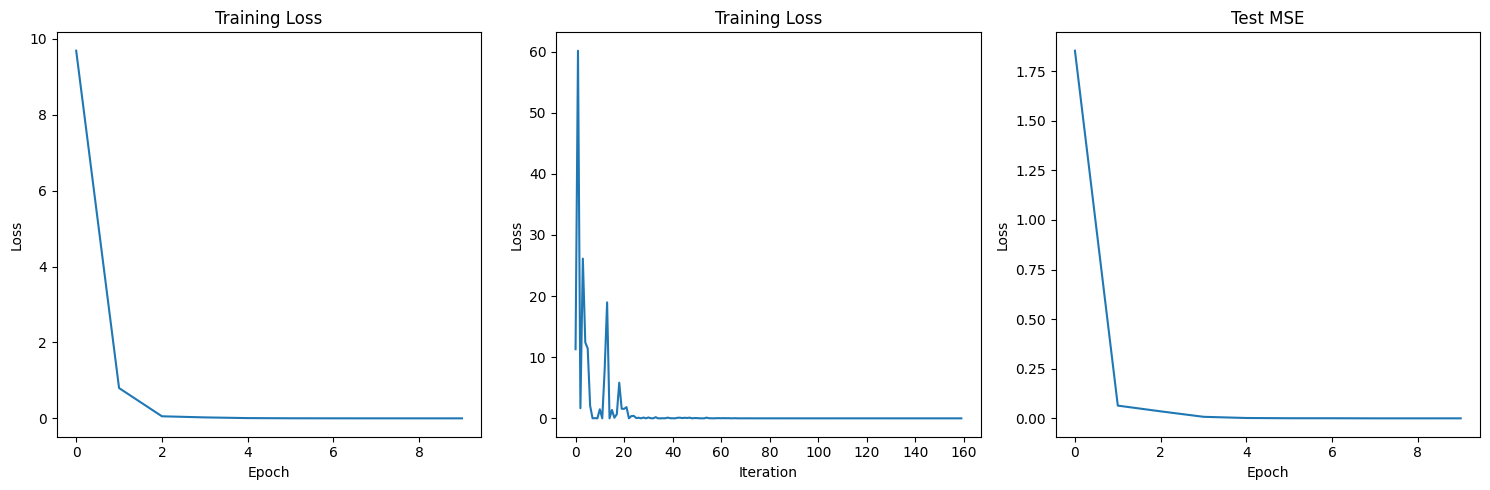

In [4]:
# Set seed
set_seed(42)

# Simple Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, num_classes=1):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# Parameters
input_dim = 10
num_classes = 1
batch_size = 1024
learning_rate = 0.1
num_epochs = 10
sigma = 7.2
h1=1e-8
h2=10
beta1=0.95
beta2=0.99

# Load data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = LinearRegression(input_dim, num_classes)

# Loss function
criterion = nn.MSELoss()

# Train with GeoClip
test_mse_geo = geoclip(
    model,
    criterion,
    train_loader,
    test_loader,
    task_type="regression",
    learning_rate=learning_rate,
    batch_size=batch_size,
    sigma=sigma,
    num_epochs=num_epochs,
    h1=h1,
    h2=h2,
    beta1=beta1,
    beta2=beta2,
    apply_geoclip=True
)

## Synthetic Data with Uncorrelated Features

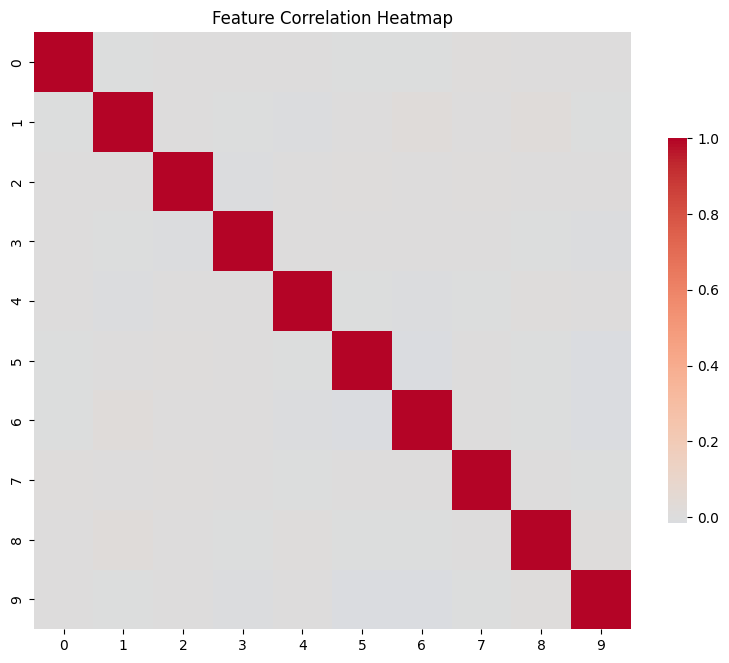

Length of training dataset: 16000
Length of testing dataset: 4000
Shape of one training sample (features): torch.Size([10])
Shape of one training sample (target): torch.Size([1])


In [5]:
def generate_synthetic_regression_data(
        n_samples=20000,
        input_dim=10,
        noise_std=0.01,
        plot_corr=True,
        seed=42):

    # Set seed
    set_seed(seed)

    # Ground truth weights and bias
    true_w = torch.randn(input_dim, 1)
    true_b = torch.randn(1)

    # Generate independent features
    X = torch.randn(n_samples, input_dim)

    # Targets with Gaussian noise
    noise = noise_std * torch.randn(n_samples, 1)
    y = X @ true_w + true_b + noise

    # Wrap into dataset
    dataset = TensorDataset(X, y)
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=seed)

    # Plot correlation matrix
    if plot_corr:
        df = pd.DataFrame(X.numpy())
        corr_matrix = df.corr()
        plt.figure(figsize=(8, 8))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": 0.5})
        plt.title("Feature Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    return train_dataset, test_dataset, true_w, true_b


# Generate synthetic data
train_dataset, test_dataset, true_w, true_b = generate_synthetic_regression_data(
    n_samples=20000, input_dim=10, noise_std=0.01, plot_corr=True, seed=42
)

print("Length of training dataset:", len(train_dataset))
print("Length of testing dataset:", len(test_dataset))
print("Shape of one training sample (features):", train_dataset[0][0].shape)
print("Shape of one training sample (target):", train_dataset[0][1].shape)

Applying geometry-aware clipping.
Epoch 1/10, Train Loss: 6.3876, Test MSE: 1.7059
Epoch 2/10, Train Loss: 0.9362, Test MSE: 0.0241
Epoch 3/10, Train Loss: 0.0091, Test MSE: 0.0002
Epoch 4/10, Train Loss: 0.0003, Test MSE: 0.0001
Epoch 5/10, Train Loss: 0.0002, Test MSE: 0.0001
Epoch 6/10, Train Loss: 0.0002, Test MSE: 0.0001
Epoch 7/10, Train Loss: 0.0002, Test MSE: 0.0001
Epoch 8/10, Train Loss: 0.0002, Test MSE: 0.0002
Epoch 9/10, Train Loss: 0.0004, Test MSE: 0.0004
Epoch 10/10, Train Loss: 0.0007, Test MSE: 0.0006


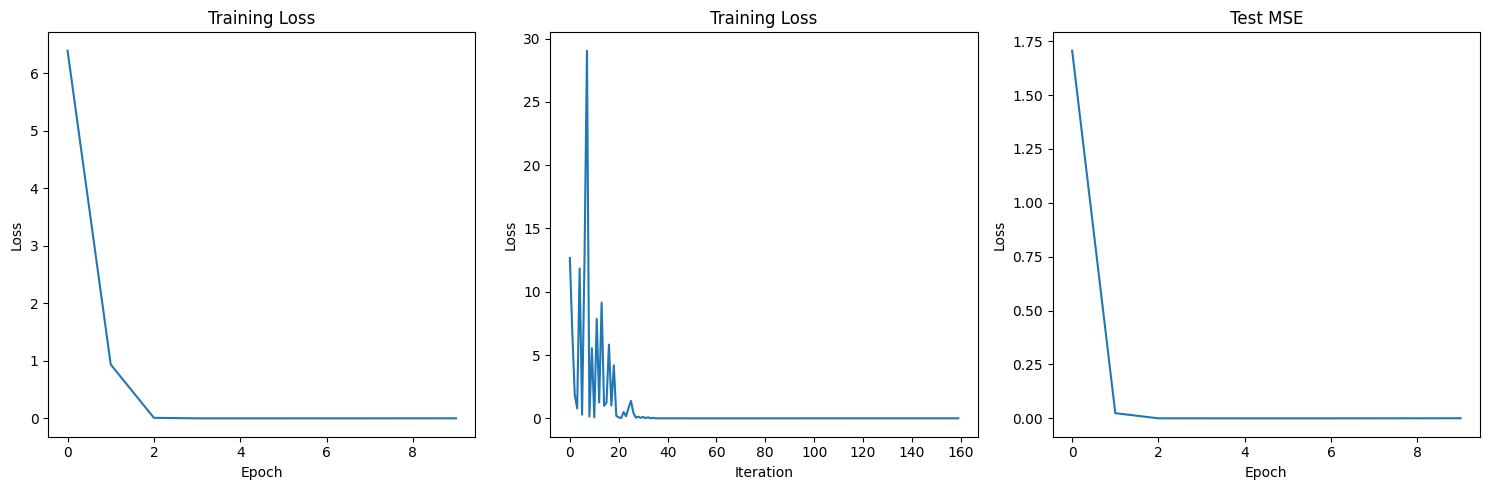

In [6]:
# Set seed
set_seed(42)

# Simple Linear Regression Model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, num_classes=1):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# Parameters
input_dim = 10
num_classes = 1
batch_size = 1024
learning_rate = 0.1
num_epochs = 10
sigma = 7.2
h1=1e-8
h2=10
beta1=0.95
beta2=0.99

# Load data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = LinearRegression(input_dim, num_classes)

# Loss function
criterion = nn.MSELoss()

# Train with GeoClip
test_mse_geo = geoclip(
    model,
    criterion,
    train_loader,
    test_loader,
    task_type="regression",
    learning_rate=learning_rate,
    batch_size=batch_size,
    sigma=sigma,
    num_epochs=num_epochs,
    h1=h1,
    h2=h2,
    beta1=beta1,
    beta2=beta2,
    apply_geoclip=True
)

# Example Usage of GeoClip with Rank-k Update (Algorithm 2)

## USPS Digits Dataset

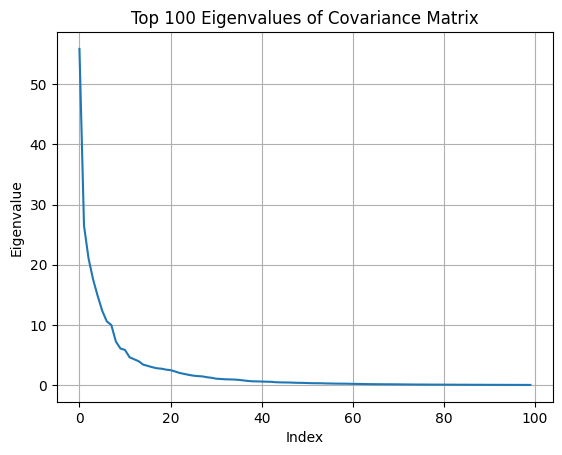

Train size: 7438, Test size: 1860


In [8]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load USPS from OpenML
usps = fetch_openml("usps", version=2, as_frame=False)

X = usps["data"]        # shape: (9298, 256) → 16x16 grayscale images flattened
# y = usps["target"].astype(int)  # digit labels (0–9)
y = usps["target"].astype(int) - 1

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wrap in DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Center the data for eigendecomposition
X_centered = X_scaled - X_scaled.mean(axis=0)

# Compute covariance matrix
cov = X_centered.T @ X_centered / (X_scaled.shape[0] - 1)

# Use NumPy to compute eigenvalues
eigvals = np.linalg.eigvalsh(cov)  # returns sorted in ascending order
eigvals_descending = eigvals[::-1]  # reverse to get descending order

# Plot top 100 eigenvalues
plt.plot(eigvals_descending[:100])
plt.title("Top 100 Eigenvalues of Covariance Matrix")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

In [9]:
# Set seed
set_seed(42)

# Simple Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.linear(x)

# Parameters
input_dim = X.shape[1]
num_classes = 10
batch_size = 1024
learning_rate = 0.5
num_epochs = 3
sigma = 4.8
k = 50
h1 = 1e-12
h2 = 10
beta1 = 0.95
beta2 = 0.98
eta = 0.01
alpha = 1
gamma = 0.2

# Load data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = LogisticRegression(input_dim, num_classes)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train using GeoClip with low-rank PCA updates
_, _, _, test_accuracies_geo = geoclip_with_rank_k_update(
    model=model,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=learning_rate,
    batch_size=batch_size,
    sigma=sigma,
    num_epochs=num_epochs,
    k=k,
    h1=h1,
    h2=h2,
    beta1=beta1,
    beta2=beta2,
    eta=eta,
    alpha=alpha,
    gamma=gamma
)

Epoch 1, Iter 1 | Train Loss: 1.3784 | Test Loss: 1.0243 | Test Acc: 0.6758
Epoch 1, Iter 2 | Train Loss: 0.0878 | Test Loss: 0.5286 | Test Acc: 0.8613
Epoch 1, Iter 3 | Train Loss: 0.0962 | Test Loss: 0.5161 | Test Acc: 0.8618
Epoch 1, Iter 4 | Train Loss: 0.6480 | Test Loss: 0.5114 | Test Acc: 0.8608
Epoch 1, Iter 5 | Train Loss: 0.1416 | Test Loss: 0.5051 | Test Acc: 0.8602
Epoch 1, Iter 6 | Train Loss: 0.8753 | Test Loss: 0.5007 | Test Acc: 0.8608
Epoch 1, Iter 7 | Train Loss: 0.3711 | Test Loss: 0.4981 | Test Acc: 0.8608
Epoch 1, Iter 8 | Train Loss: 0.1675 | Test Loss: 0.4991 | Test Acc: 0.8624


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 2, Iter 9 | Train Loss: 0.0071 | Test Loss: 0.4972 | Test Acc: 0.8629
Epoch 2, Iter 10 | Train Loss: 0.5570 | Test Loss: 0.4989 | Test Acc: 0.8624
Epoch 2, Iter 11 | Train Loss: 0.0001 | Test Loss: 0.5017 | Test Acc: 0.8624
Epoch 2, Iter 12 | Train Loss: 0.0011 | Test Loss: 0.5046 | Test Acc: 0.8629
Epoch 2, Iter 13 | Train Loss: 0.0015 | Test Loss: 0.5077 | Test Acc: 0.8624
Epoch 2, Iter 14 | Train Loss: 1.7211 | Test Loss: 0.5116 | Test Acc: 0.8634
Epoch 2, Iter 15 | Train Loss: 0.8735 | Test Loss: 0.5155 | Test Acc: 0.8651
Epoch 2, Iter 16 | Train Loss: 0.0000 | Test Loss: 0.5188 | Test Acc: 0.8629
Epoch 3, Iter 17 | Train Loss: 0.0013 | Test Loss: 0.5221 | Test Acc: 0.8613
Epoch 3, Iter 18 | Train Loss: 0.3950 | Test Loss: 0.5258 | Test Acc: 0.8618
Epoch 3, Iter 19 | Train Loss: 0.0000 | Test Loss: 0.5323 | Test Acc: 0.8624
Epoch 3, Iter 20 | Train Loss: 0.0002 | Test Loss: 0.5381 | Test Acc: 0.8618
Epoch 3, Iter 21 | Train Loss: 0.0002 | Test Loss: 0.5449 | Test Acc: 0.8602


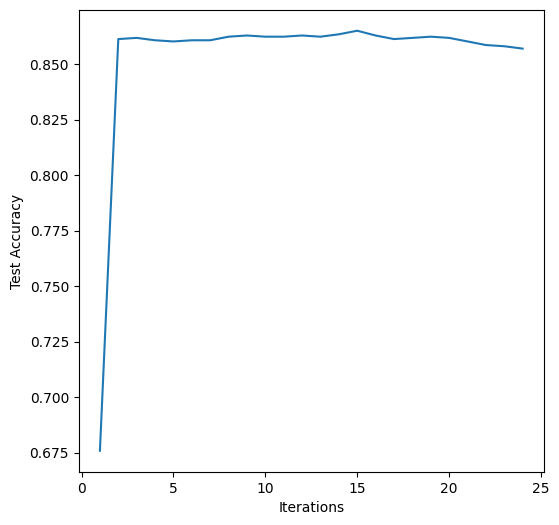

In [10]:
# Plot results
iterations = np.arange(1, len(test_accuracies_geo) + 1)

plt.figure(figsize=(6, 6))
plt.plot(iterations, test_accuracies_geo)
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.show()

## Synthetic Data with Uncorrelated Features

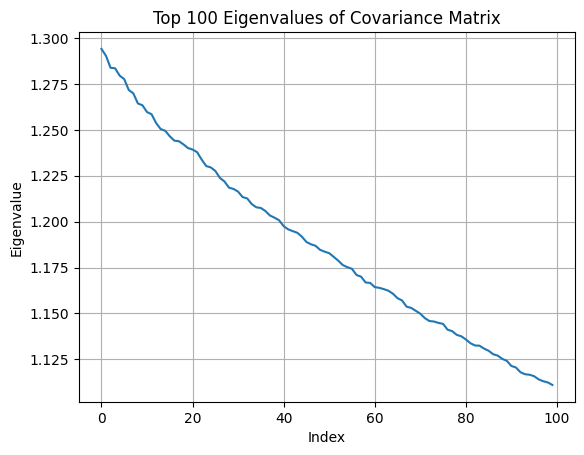

In [11]:
# Set seed
set_seed(42)

# Parameters
n_samples = 20000
input_dim = 400
n_corr = 1
n_uncorr = input_dim - n_corr

# Ground truth weights and bias
true_w = torch.randn(input_dim, 1)
true_b = torch.randn(1)

# Step 1: Generate correlated features
A_corr = torch.randn(n_corr, n_corr)
X_latent = torch.randn(n_samples, n_corr)
X_corr = X_latent @ A_corr.T

# Step 2: Generate uncorrelated features
X_uncorr = torch.randn(n_samples, n_uncorr)

# Step 3: Combine
X = torch.cat([X_corr, X_uncorr], dim=1)

# Step 4: Generate logits and labels
logits = X @ true_w + true_b
logits += 0.01 * torch.randn(n_samples, 1)
probs = torch.sigmoid(logits)
y = (probs > 0.5).long().squeeze()

# Wrap in TensorDataset
dataset = TensorDataset(X, y)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Process for inspection
X_centered = X - X.mean(dim=0)
cov = X_centered.T @ X_centered / (n_samples - 1)
eigvals = torch.linalg.eigvalsh(cov)
eigvals_descending = torch.flip(eigvals, dims=[0])

# Plot top eigenvalues
import matplotlib.pyplot as plt
plt.plot(eigvals_descending[:100])
plt.title("Top 100 Eigenvalues of Covariance Matrix")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

In [12]:
# Set seed
set_seed(42)

# Simple Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.linear(x)

# Parameters
input_dim = X.shape[1]
num_classes = 2
batch_size = 1024
learning_rate = 0.5
num_epochs = 5
sigma = 5
k = 50
h1=1e-12
h2=10
beta1=0.95
beta2=0.98
eta=0.01
alpha=1
gamma=1

# Load data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = LogisticRegression(input_dim, num_classes)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train using GeoClip with low-rank PCA updates
_, _, _, test_accuracies_geo = geoclip_with_rank_k_update(
    model=model,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=learning_rate,
    batch_size=batch_size,
    sigma=sigma,
    num_epochs=num_epochs,
    k=k,
    h1=h1,
    h2=h2,
    beta1=beta1,       # tune
    beta2=beta2,
    eta=eta,
    alpha=alpha,
    gamma=gamma        # tune
)

Epoch 1, Iter 1 | Train Loss: 0.6028 | Test Loss: 0.5479 | Test Acc: 0.7260
Epoch 1, Iter 2 | Train Loss: 0.2155 | Test Loss: 0.4705 | Test Acc: 0.8037
Epoch 1, Iter 3 | Train Loss: 0.5376 | Test Loss: 0.4615 | Test Acc: 0.8123
Epoch 1, Iter 4 | Train Loss: 0.2790 | Test Loss: 0.4526 | Test Acc: 0.8163
Epoch 1, Iter 5 | Train Loss: 0.3570 | Test Loss: 0.4473 | Test Acc: 0.8207
Epoch 1, Iter 6 | Train Loss: 0.4173 | Test Loss: 0.4395 | Test Acc: 0.8267
Epoch 1, Iter 7 | Train Loss: 0.2195 | Test Loss: 0.4336 | Test Acc: 0.8292
Epoch 1, Iter 8 | Train Loss: 0.6097 | Test Loss: 0.4282 | Test Acc: 0.8292
Epoch 1, Iter 9 | Train Loss: 0.2548 | Test Loss: 0.4217 | Test Acc: 0.8347
Epoch 1, Iter 10 | Train Loss: 0.7709 | Test Loss: 0.4157 | Test Acc: 0.8328
Epoch 1, Iter 11 | Train Loss: 0.5807 | Test Loss: 0.4095 | Test Acc: 0.8413
Epoch 1, Iter 12 | Train Loss: 0.3978 | Test Loss: 0.4047 | Test Acc: 0.8375
Epoch 1, Iter 13 | Train Loss: 0.0920 | Test Loss: 0.3998 | Test Acc: 0.8420
Epoch 1,